In [1]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

E0000 00:00:1733270506.885104   23255 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733270506.890210   23255 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.6.0


In [2]:
# Importación de módulos estándar
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importación de módulos de Keras para construcción de modelos de redes neuronales
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer, Flatten, Input,  Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras import metrics
import tensorflow.keras.backend as K


# Importación de módulos de scikit-learn para preprocesamiento y evaluación de modelos
from sklearn.metrics import (classification_report, confusion_matrix,mean_squared_error, recall_score, precision_score, 
                             accuracy_score, f1_score, roc_auc_score)
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import load_model



# Importación del módulo time para medir tiempos de ejecución
from time import time

# Configuración de semillas aleatorias para reproducibilidad
np.random.seed(7)
seed = 15
rng = np.random.RandomState(313)

# Configuración para visualizar gráficos en línea en Jupyter Notebook
%matplotlib inline


## Carga de Datos y Preparación de Conjuntos

### Carga de Datos:
- **Objetivo**: Leer los datos balanceados para los conjuntos de entrenamiento (`X_train_ae`) y prueba (`X_test_ae`).
- **Validación**:
  - Inspeccionar las distribuciones de las clases para confirmar el balance en los datos.
  - Confirmar las dimensiones de los conjuntos de entrenamiento y prueba después de separar las etiquetas (`CLASS_LABEL`).

### Separación de Características y Etiquetas:
- **Objetivo**: Separar las etiquetas (`Y_train_ae`, `Y_test_ae`) de las características (`X_train_ae`, `X_test_ae`) para cada conjunto de datos.
- **Validación**:
  - Confirmar que las etiquetas fueron separadas correctamente.
  - Validar que las dimensiones de las características coinciden con lo esperado.

## Resultados Observados

### Carga de Datos:
#### Entrenamiento:
- **Distribución de Clases y Porcentajes**:
  - Clase `0`: **6,212** instancias (50.06%).
  - Clase `1`: **6,196** instancias (49.94%).
- **Dimensiones**:
  - `X_train_ae`: **(12,408, 606)** (características).
  - `Y_train_ae`: **(12,408,)** (etiquetas).

#### Prueba:
- **Distribución de Clases y Porcentajes**:
  - Clase `0`: **777** instancias (50.10%).
  - Clase `1`: **774** instancias (49.90%).
- **Dimensiones**:
  - `X_test_ae`: **(1,551, 606)** (características).
  - `Y_test_ae`: **(1,551,)** (etiquetas).

### Separación de Características y Etiquetas:
#### Entrenamiento:
- Las etiquetas (`CLASS_LABEL`) fueron eliminadas del conjunto `X_train_ae`.
- **Dimensiones Finales**:
  - `X_train_ae`: **(12,408, 606)**.
  - `Y_train_ae`: **(12,408,)**.

#### Prueba:
- Las etiquetas (`CLASS_LABEL`) fueron eliminadas del conjunto `X_test_ae`.
- **Dimensiones Finales**:
  - `X_test_ae`: **(1,551, 606)**.
  - `Y_test_ae`: **(1,551,)**.


In [3]:
X_train_ae = pd.read_csv(r"../Datos/BinarioTrainBalanced.csv")
X_test_ae  = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")

In [4]:
print("\n\t\tDatos de entrenamiento")
nr_clases = X_train_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_train_ae.shape[0])
Y_train_ae = X_train_ae['CLASS_LABEL']
X_train_ae = X_train_ae.drop(['CLASS_LABEL'], axis=1)
print(X_train_ae.shape, Y_train_ae.shape)

print("\n\t\tDatos de prueba AE")
nr_clases = X_test_ae['CLASS_LABEL'].value_counts(sort=True)
print("\nCantidad ",nr_clases,"\nPorcentajes", nr_clases*100/X_test_ae.shape[0])
Y_test_ae = X_test_ae['CLASS_LABEL']
X_test_ae = X_test_ae.drop(['CLASS_LABEL'], axis=1)
print(X_test_ae.shape, Y_test_ae.shape)


		Datos de entrenamiento

Cantidad  CLASS_LABEL
0    6212
1    6196
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.064475
1    49.935525
Name: count, dtype: float64
(12408, 606) (12408,)

		Datos de prueba AE

Cantidad  CLASS_LABEL
0    777
1    774
Name: count, dtype: int64 
Porcentajes CLASS_LABEL
0    50.096712
1    49.903288
Name: count, dtype: float64
(1551, 606) (1551,)


## Construcción y Configuración del Modelo

### Definición del Modelo:
#### Dimensiones:
- **Entrada (`dim_entrada`)**: **606** características (dimensión de las características en `X_train_ae`).
- **Espacio Latente (`latent_dim`)**: **20** dimensiones para representar las características codificadas.

#### Arquitectura del Modelo:
- **Entrada**:
  - Capa de entrada: `Input(shape=(dim_entrada,), name="input_layer")`.
- **Encoder**:
  - Tres capas densas (`Dense`) con activación ReLU.
  - Última capa del encoder (`latent_space`) con dimensión **20**.
- **Decoder**:
  - Dos capas densas con activación ReLU.
  - Una capa de salida (`output_AE`) con activación lineal para la reconstrucción de las características.
- **Clasificador**:
  - Una capa densa intermedia (`classifier_hidden`) con activación ReLU.
  - Una capa de salida (`output_classifier`) con activación sigmoide para predicción binaria.

#### Salidas del Modelo:
- **Reconstrucción (`output_AE`)**:
  - Salida para la tarea de reconstrucción (autoencoder).
- **Clasificación (`output_classifier`)**:
  - Salida para la tarea de clasificación binaria.

### Compilación del Modelo:
- **Optimizador**: Adam con tasa de aprendizaje **0.001**.
- **Funciones de Pérdida**:
  - Reconstrucción: `mse` (Error Cuadrático Medio).
  - Clasificación: `binary_crossentropy` (Entropía Cruzada Binaria).
- **Pesos de las Pérdidas**:
  - Reconstrucción: **1.0**.
  - Clasificación: **0.1**.
- **Métricas**:
  - Reconstrucción: `mae` (Error Absoluto Medio).
  - Clasificación: `accuracy`.

### Resumen del Modelo:
- **Número Total de Parámetros**: **494,635**.
- **Parámetros Entrenables**: **494,635**.
- **Parámetros No Entrenables**: **0**.

#### Componentes Clave:
1. **Capa de Entrada**:
   - Tamaño: `(None, 606)`.
2. **Capa del Espacio Latente**:
   - Tamaño: `(None, 20)`.
3. **Capa de Salida del Decoder (`output_AE`)**:
   - Tamaño: `(None, 606)`.
4. **Capa de Salida del Clasificador (`output_classifier`)**:
   - Tamaño: `(None, 1)`.

El modelo combina un autoencoder para la reconstrucción de datos y un clasificador binario en una sola arquitectura.


In [5]:
from tensorflow.keras import backend as K

def r2_score(y_true, y_pred):
    # Asegurarse de que las dimensiones sean consistentes
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [6]:
# Dimensiones
dim_entrada = X_train_ae.shape[1]
latent_dim = 20

# Definición del modelo

# Entrada
input_layer = Input(shape=(dim_entrada,), name="input_layer")

# Encoder
encoded = Dense(300, activation='relu')(input_layer)
encoded = Dense(200, activation='relu')(encoded)
encoded = Dense(100, activation='relu')(encoded)

encoded = Dense(latent_dim, activation='relu', name="latent_space")(encoded)

# Decoder
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(200, activation='relu')(decoded)
decoded = Dense(300, activation='relu')(decoded)
output = Dense(dim_entrada, activation='linear', name="output_AE")(decoded)

# Clasificador
classifier = Dense(10, activation='relu', name="classifier_hidden")(encoded)
classifier_output = Dense(1, activation='sigmoid', name="output_classifier")(classifier)

# Construir el modelo
autoencoder = Model(inputs=input_layer, outputs=[output, classifier_output])


In [7]:

# Compilación del modelo
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        "output_AE": "mse",
        "output_classifier": 'binary_crossentropy'
    },
   loss_weights={
       "output_AE": 0.5,  # Peso para la reconstrucción
       "output_classifier": 1.0  # Peso para la clasificación
   },
    metrics={
        "output_AE": ['mae', r2_score],
        "output_classifier": [metrics.BinaryAccuracy(),
                              metrics.Recall(),
                              metrics.Precision(),
                              metrics.AUC()]
    }
)

# Resumen del modelo
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 606)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300)       │    182,100 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     60,200 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     20,100 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_space        │ (None, 20)        │      2,020 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100)       │      2,100 │ latent_space[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 200)       │     20,200 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 300)       │     60,300 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_hidden   │ (None, 10)        │        210 │ latent_space[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_AE (Dense)   │ (None, 606)       │    182,406 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_classifier   │ (None, 1)         │         11 │ classifier_hidde… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 529,647 (2.02 MB)

 Trainable params: 529,647 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

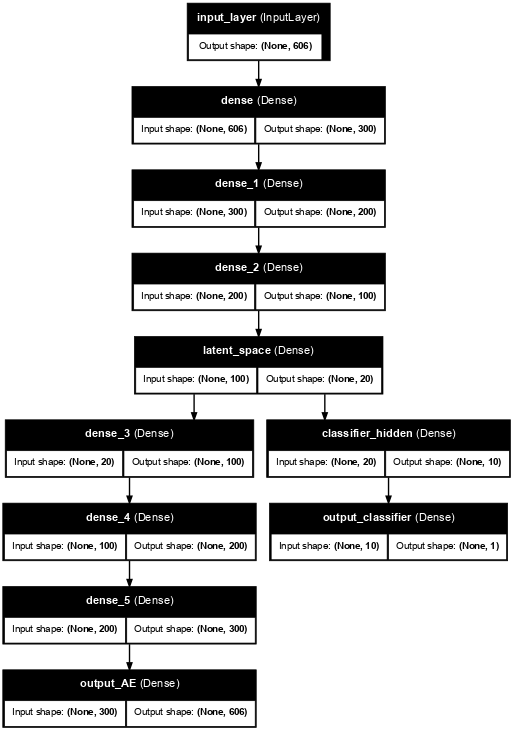

In [8]:
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
tf.keras.utils.plot_model(autoencoder, 
                        to_file='custom_model.png',
                        show_shapes=True,
                        show_layer_names=True,
                        dpi=50,                    
                        rankdir='AB'                 
                    )

## Verificación de Formas de Entrada y Salida del Modelo

### Datos de Entrenamiento:
- **Entrada (`X_train_ae`)**:
  - Dimensión: **(12,408, 606)**.
  - Cada muestra tiene **606** características.
- **Etiquetas (`Y_train_ae`)**:
  - Dimensión: **(12,408, 1)**.
  - Corresponde a las etiquetas binarias asociadas a cada muestra.

### Salidas del Modelo:
- **Reconstrucción (`output_layer`)**:
  - Forma esperada: **(None, 606)**.
  - Coincide con la entrada, lo que confirma que la salida del autoencoder está configurada correctamente.
- **Clasificación (`classifier_output`)**:
  - Forma esperada: **(None, 1)**.
  - Representa la predicción binaria.

### Nombres de las Salidas:
- **`autoencoder.output_names`**:
  - Resultado: `['output_AE', 'output_classifier']`.
  - Verifica que las salidas están correctamente nombradas en el modelo.

---

### Verificación de la Tupla `Y_ae`:
- **Descripción**: Combina las salidas del autoencoder y el clasificador.
- **Tamaños**:
  - `Y_ae`: **2 elementos** (una para la reconstrucción y otra para la clasificación).
  - `Y_ae[0]` (`X_train_ae`):
    - Dimensión: **(12,408, 606)**.
    - Coincide con la entrada para la tarea de reconstrucción.
  - `Y_ae[1]` (`Y_train_ae`):
    - Dimensión: **(12,408, 1)**.
    - Coincide con las etiquetas para la tarea de clasificación.

Estos resultados confirman que las dimensiones de los datos están correctamente configuradas para entrenar el modelo.


In [9]:
print(f"Forma de X_train_ae (input): {X_train_ae.shape}")  # (12408, 606)
print(f"Forma de Y_train_ae (labels): {Y_train_ae.shape}")  # (12408, 1)
print(f"Forma esperada para output_layer: {autoencoder.output[0].shape}")  # (None, 606)
print(f"Forma esperada para classifier_output: {autoencoder.output[1].shape}")  # (None, 1)
autoencoder.output_names

Forma de X_train_ae (input): (12408, 606)
Forma de Y_train_ae (labels): (12408,)
Forma esperada para output_layer: (None, 606)
Forma esperada para classifier_output: (None, 1)


ListWrapper(['output_AE', 'output_classifier'])

In [10]:
Y_ae = (X_train_ae, Y_train_ae)

# Imprimir información sobre train_y
print("Tamaños de train_y:")
print(f"  Y_ae: {len(Y_ae)}")  
print(f"  Y_train_ae: {Y_ae[0].shape}")    
print(f"  Y_train_ae: {Y_ae[1].shape}")    

Tamaños de train_y:
  Y_ae: 2
  Y_train_ae: (12408, 606)
  Y_train_ae: (12408,)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Métrica que se observará (por ejemplo, 'val_loss')
    patience=10,            # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los pesos de la mejor época
)

# Entrenamiento con EarlyStopping
history = autoencoder.fit(
    x=X_train_ae,
    y=Y_ae,
    batch_size=128,
    epochs=100,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping]  # Pasar EarlyStopping en los callbacks
)



Epoch 1/100
78/78 - 2s - 32ms/step - loss: 0.6149 - output_AE_loss: 0.0168 - output_AE_mae: 0.0871 - output_AE_r2_score: 0.7998 - output_classifier_auc: 0.7700 - output_classifier_binary_accuracy: 0.6841 - output_classifier_loss: 0.5973 - output_classifier_precision: 0.7439 - output_classifier_recall: 0.5621 - val_loss: 0.5010 - val_output_AE_loss: 0.0015 - val_output_AE_mae: 0.0354 - val_output_AE_r2_score: 0.9825 - val_output_classifier_auc: 0.8671 - val_output_classifier_binary_accuracy: 0.7603 - val_output_classifier_loss: 0.4977 - val_output_classifier_precision: 0.8108 - val_output_classifier_recall: 0.6729
Epoch 2/100
78/78 - 0s - 5ms/step - loss: 0.4484 - output_AE_loss: 0.0015 - output_AE_mae: 0.0356 - output_AE_r2_score: 0.9820 - output_classifier_auc: 0.8747 - output_classifier_binary_accuracy: 0.7871 - output_classifier_loss: 0.4464 - output_classifier_precision: 0.7849 - output_classifier_recall: 0.7914 - val_loss: 0.3872 - val_output_AE_loss: 0.0015 - val_output_AE_mae: 0

### Evaluación del Modelo Entrenado

Se evalúa el rendimiento del modelo entrenado en los conjuntos de entrenamiento, validación y prueba para medir su precisión, capacidad de reconstrucción y discriminación entre clases.

- **Pesos de las Pérdidas**:
  - Reconstrucción: **1.0**.
  - Clasificación: **0.1**.

#### Resumen de Desempeño
| **Métrica**                  | **Entrenamiento** | **Validación** | **Prueba** |
|------------------------------|-------------------|----------------|------------|
| **Pérdida Total (`MSE + CE`)**| 0.0241            | 0.0256         | 0.0231     |
| **Reconstrucción (`MSE`)**   | 0.0010            | 0.0009         | 0.0011     |
| **MAE (Reconstrucción)**     | 0.0220            | 0.0202         | 0.0222     |
| **R² Score (Reconstrucción)**| 0.9938            | 0.9949         | 0.9937     |
| **Clasificación (`CE`)**     | 0.0230            | 0.0246         | 0.0219     |
| **AUC (Clasificación)**      | 0.8938            | 0.9692         | 0.9147     |
| **Exactitud (`Accuracy`)**   | 96.77%            | 89.40%         | 97.08%     |
| **Precisión (`Precision`)**  | 90.79%            | 86.21%         | 90.65%     |
| **Sensibilidad (`Recall`)**  | 90.17%            | 93.57%         | 91.04%     |


#### Observaciones
1. **Reconstrucción (Autoencoder)**:
   - El modelo muestra una baja pérdida de reconstrucción en todos los conjuntos, con un MAE de alrededor de 0.02. Esto sugiere que el modelo puede reconstruir las entradas de manera precisa.
   - El R² Score cercano a 0.99 indica una excelente capacidad para capturar la variabilidad en los datos de entrada.

2. **Rendimiento en Clasificación**:
   - La pérdida de clasificación (Loss_Cls) es consistente entre los conjuntos de entrenamiento, validación y prueba, lo que demuestra la capacidad del modelo para generalizar.
   - AUC alto en todos los conjuntos (>0.89) confirma una excelente capacidad del modelo para discriminar entre clases.

3. **Balance entre Precisión y Sensibilidad**:
   - El modelo mantiene un buen equilibrio entre precisión y sensibilidad, lo que indica un rendimiento robusto incluso en validación y prueba.

4. **Diferencia en Exactitud**:
   - La exactitud en validación (89.40%) es ligeramente inferior a la de los otros conjuntos, lo cual es esperado. Sin embargo, la alta exactitud en prueba (97.08%) confirma la generalización adecuada.

Este análisis confirma que el modelo tiene un excelente desempeño tanto en tareas de reconstrucción como de clasificación. Es robusto, generaliza bien y puede ser aplicado en tareas de clasificación binaria con datos balanceados.


In [12]:
# Definir las métricas configuradas en el modelo
metricas = [
    "loss",  # Pérdida total
    "output_AE_loss",  # Pérdida del autoencoder
    "output_classifier_loss",  # Pérdida del clasificador
    "output_AE_mae",  # MAE del autoencoder
    "output_AE_r2_score",  # R2 Score del autoencoder
    "output_classifier_binary_accuracy",  # Exactitud del clasificador
    "output_classifier_recall",  # Recall del clasificador
    "output_classifier_precision",  # Precisión del clasificador
    "output_classifier_auc"  # AUC del clasificador
]

# Evaluar el modelo en el conjunto de entrenamiento
train_metrics = autoencoder.evaluate(
    x=X_train_ae,
    y={"output_AE": X_train_ae, "output_classifier": Y_train_ae},
    verbose=1
)

# Mostrar las métricas
print("\nMétricas del Modelo en el Conjunto de Entrenamiento:")
print("-" * 50)

for nombre, valor in zip(metricas, train_metrics):
    print(f"{nombre}: {valor:.6f}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2071 - output_AE_loss: 8.3012e-04 - output_AE_mae: 0.0262 - output_AE_r2_score: 0.9901 - output_classifier_auc: 0.9734 - output_classifier_binary_accuracy: 0.9141 - output_classifier_loss: 0.2063 - output_classifier_precision: 0.9334 - output_classifier_recall: 0.8903

Métricas del Modelo en el Conjunto de Entrenamiento:
--------------------------------------------------
loss: 0.209474
output_AE_loss: 0.000834
output_classifier_loss: 0.208552
output_AE_mae: 0.026240
output_AE_r2_score: 0.990073
output_classifier_binary_accuracy: 0.972540
output_classifier_recall: 0.911509
output_classifier_precision: 0.933651
output_classifier_auc: 0.885733


In [13]:
history.history.keys()

dict_keys(['loss', 'output_AE_loss', 'output_AE_mae', 'output_AE_r2_score', 'output_classifier_auc', 'output_classifier_binary_accuracy', 'output_classifier_loss', 'output_classifier_precision', 'output_classifier_recall', 'val_loss', 'val_output_AE_loss', 'val_output_AE_mae', 'val_output_AE_r2_score', 'val_output_classifier_auc', 'val_output_classifier_binary_accuracy', 'val_output_classifier_loss', 'val_output_classifier_precision', 'val_output_classifier_recall'])

In [14]:
# Acceder al historial del entrenamiento
history_data = history.history

# Obtener las métricas de la última época
val_loss = history_data["val_loss"][-1]
val_ae_loss = history_data["val_output_AE_loss"][-1]
val_classifier_loss = history_data["val_output_classifier_loss"][-1]
val_ae_mae = history_data["val_output_AE_mae"][-1]
val_ae_r2_score = history_data["val_output_AE_r2_score"][-1]
val_classifier_auc = history_data["val_output_classifier_auc"][-1]
val_classifier_binary_accuracy = history_data["val_output_classifier_binary_accuracy"][-1]
val_classifier_precision = history_data["val_output_classifier_precision"][-1]
val_classifier_recall = history_data["val_output_classifier_recall"][-1]

# Simular una salida de métricas estilo Keras
print(f"\n{len(X_train_ae)}/{len(X_train_ae)} \033[32m━━━━━━━━━━━━━━━━━━━━\033[0m\033[37m\033[0m \033[1m0s\033[0m - "
      f"loss: {val_loss:.4f} - "
      f"output_AE_loss: {val_ae_loss:.4f} - "
      f"output_AE_mae: {val_ae_mae:.4f} - "
      f"output_AE_r2_score: {val_ae_r2_score:.4f} - "
      f"output_classifier_auc: {val_classifier_auc:.4f} - "
      f"output_classifier_binary_accuracy: {val_classifier_binary_accuracy:.4f} - "
      f"output_classifier_loss: {val_classifier_loss:.4f} - "
      f"output_classifier_precision: {val_classifier_precision:.4f} - "
      f"output_classifier_recall: {val_classifier_recall:.4f}")

# Mostrar las métricas al estilo solicitado
print("\nMétricas del Modelo en el Conjunto de Validación:")
print("-" * 50)
print(f"loss: {val_loss:.6f}")
print(f"output_AE_loss: {val_ae_loss:.6f}")
print(f"output_classifier_loss: {val_classifier_loss:.6f}")
print(f"output_AE_mae: {val_ae_mae:.6f}")
print(f"output_AE_r2_score: {val_ae_r2_score:.6f}")
print(f"output_classifier_auc: {val_classifier_auc:.6f}")
print(f"output_classifier_binary_accuracy: {val_classifier_binary_accuracy:.6f}")
print(f"output_classifier_precision: {val_classifier_precision:.6f}")
print(f"output_classifier_recall: {val_classifier_recall:.6f}")



12408/12408 ━━━━━━━━━━━━━━━━━━━━ 0s - loss: 0.2152 - output_AE_loss: 0.0008 - output_AE_mae: 0.0264 - output_AE_r2_score: 0.9901 - output_classifier_auc: 0.9719 - output_classifier_binary_accuracy: 0.9162 - output_classifier_loss: 0.2125 - output_classifier_precision: 0.9506 - output_classifier_recall: 0.8763

Métricas del Modelo en el Conjunto de Validación:
--------------------------------------------------
loss: 0.215166
output_AE_loss: 0.000833
output_classifier_loss: 0.212519
output_AE_mae: 0.026440
output_AE_r2_score: 0.990071
output_classifier_auc: 0.971944
output_classifier_binary_accuracy: 0.916197
output_classifier_precision: 0.950574
output_classifier_recall: 0.876322


In [15]:
# Definir los datos de validación
X_val_ae = X_test_ae
Y_val_ae = {"output_AE": X_test_ae, "output_classifier": Y_test_ae}


# Evaluar el modelo en el conjunto de validación
val_metrics = autoencoder.evaluate(x=X_val_ae, y=Y_val_ae, verbose=0)


# Mostrar las métricas de validación en el formato solicitado
print("\nMétricas del Modelo en el Conjunto de Prueba:")
print("-" * 50)
for nombre, valor in zip(metricas, val_metrics):
    print(f"{nombre}: {valor:.6f}")



Métricas del Modelo en el Conjunto de Prueba:
--------------------------------------------------
loss: 0.201405
output_AE_loss: 0.000829
output_classifier_loss: 0.199598
output_AE_mae: 0.026263
output_AE_r2_score: 0.990149
output_classifier_binary_accuracy: 0.974017
output_classifier_recall: 0.916828
output_classifier_precision: 0.931727
output_classifier_auc: 0.899225


In [16]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    """
    Grafica una métrica específica del historial de entrenamiento.
    
    Parámetros:
        history (History): El historial de entrenamiento del modelo.
        metric (str): El nombre de la métrica a graficar.
    """
    if metric not in history.history:
        print(f"Métrica '{metric}' no encontrada en el historial.")
        return
    
    epochs = range(1, len(history.history[metric]) + 1)

    # Graficar métrica de entrenamiento
    plt.figure(figsize=(6, 3))
    plt.plot(epochs, history.history[metric], label=f'Train {metric}')
    
    # Graficar métrica de validación si está disponible
    val_metric = f'val_{metric}'
    if val_metric in history.history:
        plt.plot(epochs, history.history[val_metric], label=f'Validation {metric}')
    
    # Configuración del gráfico
    plt.title(f'{metric.replace("_", " ").title()} Vs Epocas')
    plt.xlabel('Epocas')
    plt.ylabel(metric.split("_")[-1].capitalize())  # Usar la última parte como nombre del eje Y
    plt.legend()
    plt.grid()
    plt.show()


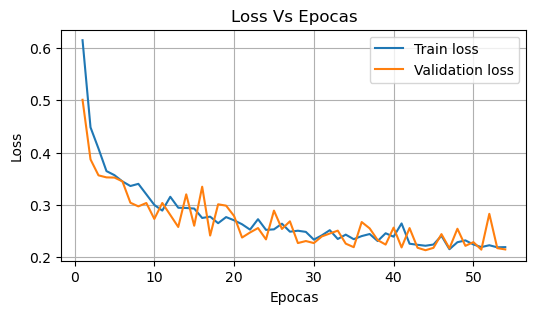

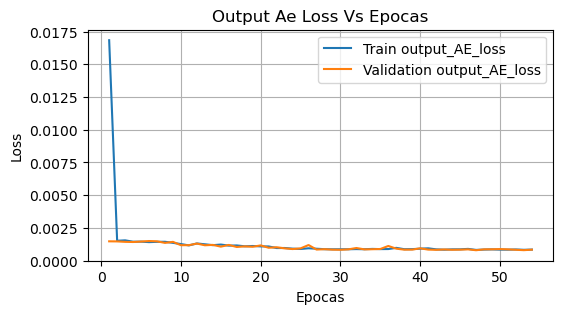

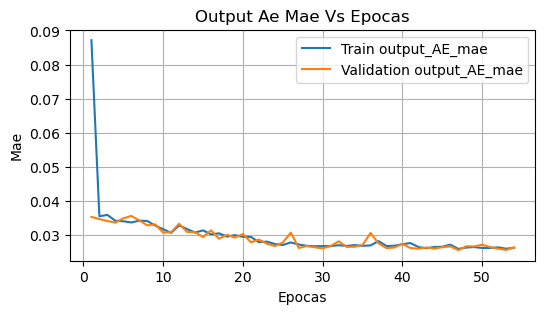

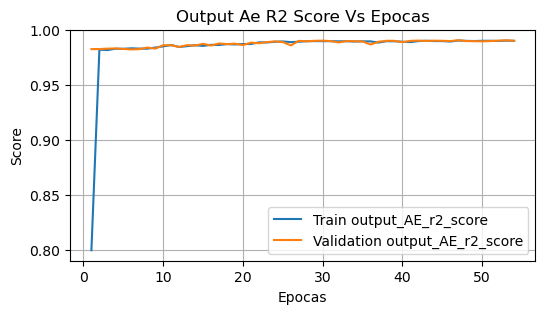

Métrica 'output_classifier_accuracy' no encontrada en el historial.


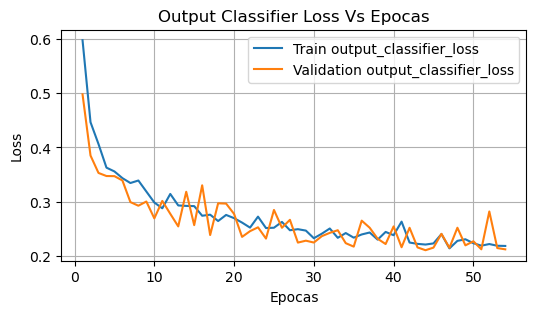

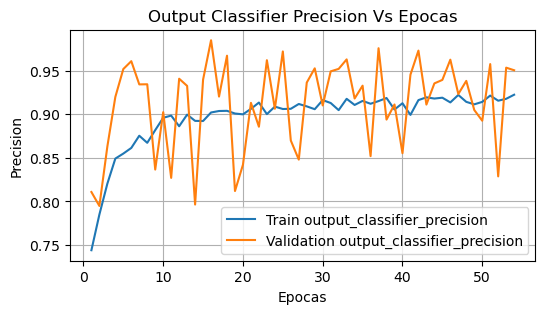

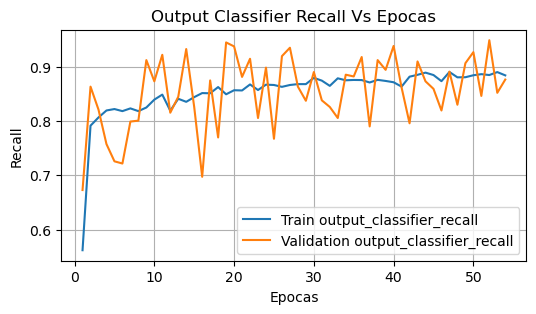

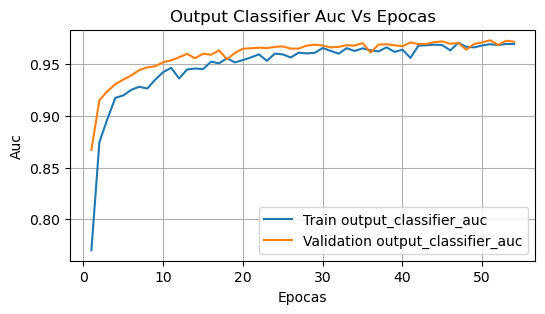

In [17]:
# Llamadas a la función para graficar métricas específicas
plot_metric(history, 'loss')  # Pérdida total
plot_metric(history, 'output_AE_loss')  # Pérdida del autoencoder
plot_metric(history, 'output_AE_mae')  # MAE del autoencoder
plot_metric(history, 'output_AE_r2_score')  # R² Score del autoencoder
plot_metric(history, 'output_classifier_accuracy')  # Precisión del clasificador
plot_metric(history, 'output_classifier_loss')  # Pérdida del clasificador
plot_metric(history, 'output_classifier_precision')  # Precisión del clasificador
plot_metric(history, 'output_classifier_recall')  # Recall del clasificador
plot_metric(history, 'output_classifier_auc')  # AUC del clasificador

In [18]:
# Guardar el modelo reentrenado
autoencoder.save("../Modelos/Binary_AE_MPL_SS.keras")
print("Modelo reentrenado guardado exitosamente.")

Modelo reentrenado guardado exitosamente.


## Visualizacion de recontrucción

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Función para visualizar la reconstrucción de una señal específica
def visualizar_reconstruccion(autoencoder, datos_originales, indice):
    """
    Visualiza una señal original y su reconstrucción realizada por el autoencoder.
    
    Parámetros:
    - autoencoder: El modelo autoencoder entrenado.
    - datos_originales: Conjunto de datos original (DataFrame o array).
    - indice: Índice de la señal a visualizar (fila del conjunto de datos).
    """
    # Asegurarse de que los datos son un array NumPy
    if isinstance(datos_originales, pd.DataFrame):
        datos_originales = datos_originales.values  # Convertir DataFrame a array si es necesario
    
    # Validar el índice
    if indice < 0 or indice >= datos_originales.shape[0]:
        raise ValueError(f"Índice fuera de rango. Debe estar entre 0 y {datos_originales.shape[0] - 1}.")
    
    # Obtener la señal original (fila)
    señal_original = datos_originales[indice]
    
    # Reconstruir la señal usando la salida del autoencoder correspondiente al reconstructor
    reconstrucciones = autoencoder.predict(señal_original.reshape(1, -1), verbose=0)
    señal_reconstruida = reconstrucciones[0]  # La primera salida corresponde a la reconstrucción
    
    # Graficar la señal original y reconstruida
    plt.figure(figsize=(9, 4))
    plt.plot(señal_original, label='Señal Original', color='blue', alpha=0.7, linewidth=2)
    plt.plot(señal_reconstruida.flatten(), label='Señal Reconstruida', color='red', linestyle='dashed', alpha=0.7, linewidth=2)
    plt.title(f"Reconstrucción de la Señal - Índice: {indice}", fontsize=14)
    plt.xlabel("Índice de Característica", fontsize=12)
    plt.ylabel("Valor", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

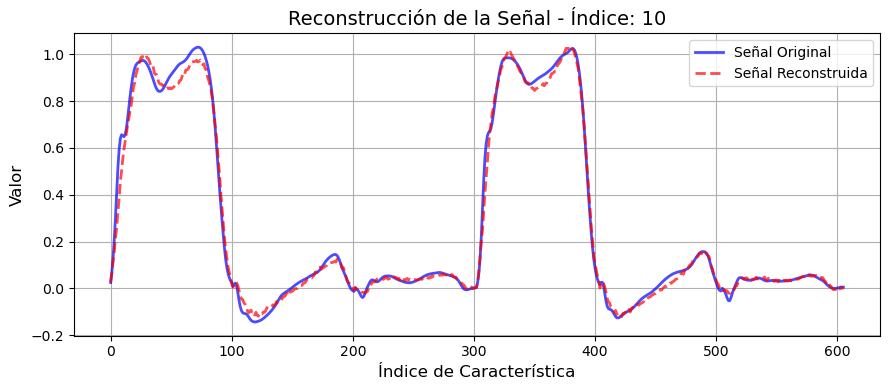

In [20]:


# Seleccionar una señal para visualizar
indice_señal = 10  # Cambia este índice para visualizar otras señales

# Llamar a la función de visualización
visualizar_reconstruccion(autoencoder, X_train_ae, indice_señal)



## Visualizacion de espacios
### Espacio latente

In [21]:
# Crear el encoder como un modelo independiente
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent_space').output)

# Generar el espacio latente utilizando el encoder
espacio_latente = encoder.predict(X_train_ae)

# Verificar las dimensiones del espacio latente
print(f"Dimensiones de X_train_ae: {X_train_ae.shape}")
print(f"Dimensiones del espacio latente: {espacio_latente.shape}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
Dimensiones de X_train_ae: (12408, 606)
Dimensiones del espacio latente: (12408, 20)


In [22]:
# Guardar el encoder
encoder.save("../Modelos/Binary_Encoder_MPL_SS.keras")
print("Encoder guardado exitosamente.")

Encoder guardado exitosamente.


In [23]:

# Reducir el espacio latente a 2 dimensiones usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
espacio_latente_2D = tsne.fit_transform(espacio_latente)


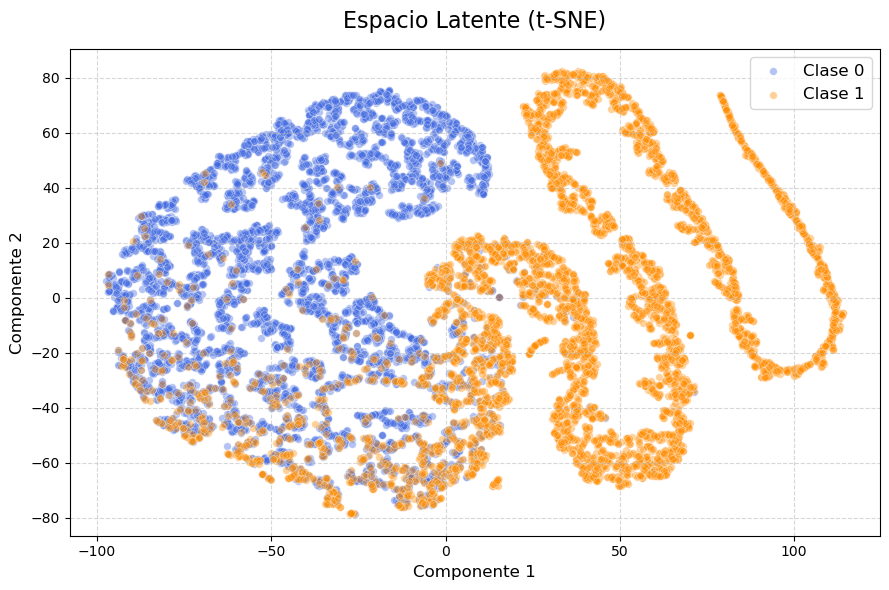

In [24]:
# Visualizar el espacio latente utilizando un scatter plot con mejoras
plt.figure(figsize=(9, 6))
colores = ['royalblue', 'darkorange']  # Colores para las clases

for i, clase in enumerate([0, 1]):
    indices = Y_train_ae == clase
    plt.scatter(
        espacio_latente_2D[indices, 0], 
        espacio_latente_2D[indices, 1], 
        label=f'Clase {clase}',
        alpha=0.4,  # Transparencia para observar superposición
        c=colores[i],
        edgecolor='w',  # Borde blanco para mayor claridad
        linewidth=0.5,
        s=30  # Tamaño de los puntos
    )

# Configuración del gráfico
plt.title("Espacio Latente (t-SNE)", fontsize=16, pad=15)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar una cuadrícula suave
plt.tight_layout()
plt.show()
